In [189]:
import numpy as np
import pandas as pd
from sklearn import model_selection, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#### Data Preprocessing

In [ ]:
df = pd.read_csv("data/Cancer_data.csv")

missing_values = df.isna().sum()
# print(f"Missing values:\n{missing_values[missing_values > 0]}")  # Only prints columns with missing values

# Transform feature from string to binary. Benign is now '0', and Malignant is '1'.
df["diagnosis"] = df["diagnosis"].map({"B": 0, "M": 1})

# print(df.iloc[0])

# Select target attribute
y = df["diagnosis"]

# Drop useless features
X = df.drop(["Unnamed: 32", "diagnosis", "id"], axis=1)
# print(df.columns)

X = np.array(X)
y = np.array(y)


scaler = StandardScaler()
X = scaler.fit_transform(X)

# Manual standardization
# mean = np.mean(X, axis=0)  # Compute mean for each feature
# std = np.std(X, axis=0)  # Compute standard deviation for each feature
# # Avoid division by zero
# std[std == 0] = 1  
# X = (X - mean) / std  # Standardization formula

# NOTE: Might be worth handling class imbalances somehow, currently it is 357(benign) to 212(malignant)
# NOTE: Consider other model performance measurements than simply missclassification rate, maybe specificity(FNR). Consider ROC/AUC
# NOTE: Possible models: Logistic Regression (Done), KNN(Done), SVM(Not done), NN(Not done), Random Forests(Not done). Bagged/Boosted models
# NOTE: Consider LOOCV instead of K-Fold CV
# NOTE: Try sequential feature selection?
# NOTE: Set random states to make results reproducible
# NOTE: Visualization of data. Pairwise feature scatter plot. PCA?

#### Building Base Models

In [205]:
class BaseLogisticRegression:
    def __init__(self, learning_rate=0.00001, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations=num_iterations
        self.weights = None

    def sigmoid(self, x):
        return 1 / (1+np.exp(-x))
        # return np.where(x >= 0, 
        #             1 / (1 + np.exp(-x)), 
        #             np.exp(x) / (1 + np.exp(x)))

    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        for i in range(self.num_iterations):
            p = self.sigmoid(X @ self.weights)
            lossGradient = X.T @ (y - p) / num_samples
            self.weights = self.weights + self.learning_rate * (lossGradient)
            
            # Print loss
            # if i % 100 == 0:  # Print every 100 iterations
            #     loss = -np.mean(y * np.log(p + 1e-15) + (1 - y) * np.log(1 - p + 1e-15))
            #     print(f"Iteration {i}: Loss = {loss:.4f}")

    def predict_proba(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        probs = self.sigmoid(X @ self.weights)
        return np.column_stack([1 - probs, probs])  # Convert to (n_samples, 2) format

    def predict(self, X, threshold=0.5):
        # X = np.hstack([np.ones([X.shape[0], 1]), X])
        probabilities = self.predict_proba(X)[:,1]

        # linear_combination = X @ self.weights
        # activated = self.sigmoid(linear_combination)
        # prediction = activated > threshold
        return probabilities > threshold
    
class BaseKNN:
    def __init__(self, X, y, K=5, distanceMeasure="Euclidean"):
        self.K = K
        self.X = X
        self.y = y
        self.distanceMeasure = distanceMeasure

    def fit(self, X, y):
        self.X = X
        self.y = y

    def getDistance(self, x1, x2):
        if self.distanceMeasure == "Euclidean":
            # distance = np.sqrt(np.sum((x1 - x2)**2))
            distance = np.linalg.norm(x1 - x2)
        return distance

    def get_K_NN(self, x):
        distances = np.array([self.getDistance(row, x) for row in self.X])
        K_neighbours_indices = np.argsort(distances)[:self.K]
        NN_classes = self.y[K_neighbours_indices]
        
        return NN_classes
    
    def predict(self, X):
        predictions = [stats.mode(self.get_K_NN(x), keepdims=False).mode for x in X]
        return np.array(predictions)
        # K_NN = self.get_K_NN(x)
        # # print(K_NN.shape)
        # return stats.mode(K_NN)

#### Evaluating Models

In [206]:
def get_kfold_accuracy(K, model, X, y):
    CV = model_selection.KFold(n_splits=K, shuffle=True)

    model_errors = np.zeros(K)

    i = 0
    for train_index, test_index in CV.split(X):
        # extract training and test set for current CV fold
        X_train, y_train = X[train_index, :], y[train_index]
        X_test, y_test = X[test_index, :], y[test_index]

        
        model.fit(X_train, y_train)

        y_est = model.predict(X_test)
        

        missclass_rate = np.sum(y_est != y_test) / len(y_test)

        model_errors[i] = missclass_rate
        i += 1

    error = model_errors.mean()
    accuracy = 1 - error
    return accuracy, error

def get_kfold_roc(K, model, X, y):
    CV = model_selection.KFold(n_splits=K, shuffle=True)
    
    all_y_true = []
    all_y_prob = []

    for train_index, test_index in CV.split(X):
        X_train, y_train = X[train_index, :], y[train_index]
        X_test, y_test = X[test_index, :], y[test_index]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]  # Get probability estimates

        all_y_true.extend(y_test)
        all_y_prob.extend(y_prob)

    # Compute overall ROC
    fpr, tpr, thresholds = metrics.roc_curve(all_y_true, all_y_prob)
    auc = metrics.auc(fpr, tpr)

    return fpr, tpr, auc, thresholds

In [207]:
def plot_roc_curve(fpr, tpr, auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random guess line
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

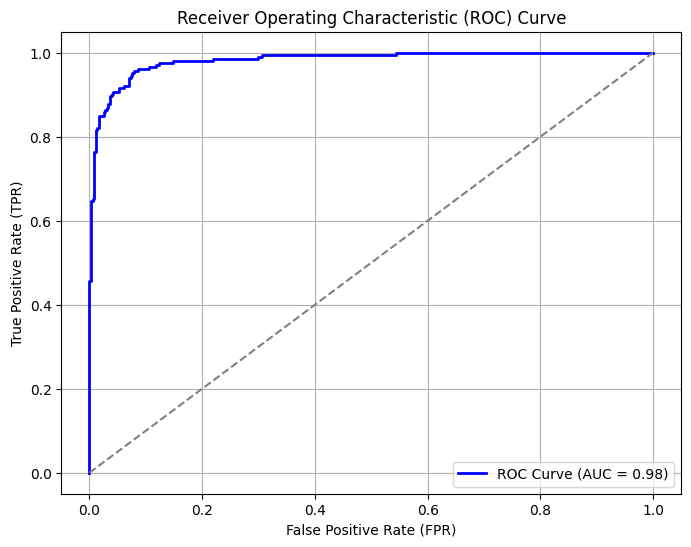

In [208]:
fpr, tpr, auc, thresholds = get_kfold_roc(10, BaseLogisticRegression(num_iterations=1000), X, y)
# fpr2, tpr2, auc2, thresholds2 = get_kfold_roc(10, LogisticRegression(), X, y)

plot_roc_curve(fpr, tpr, auc)

# for i in range(len(thresholds)):
#     print(f"Threshold: {thresholds[i]:.8f}, FPR: {fpr[i]:.8f}, TPR: {tpr[i]:.8f}")

In [214]:
import warnings 
warnings.filterwarnings("ignore")
# Compare base Logistic Regression to task Logistic Regression through K-fold cross validation
base_accuracy, base_error = get_kfold_accuracy(10, BaseLogisticRegression(num_iterations=1000), X, y)
nonbase_accuracy, nonbase_error = get_kfold_accuracy(10, LogisticRegression(max_iter=1000), X, y)

print(f"Base model accuracy: {base_accuracy}\nBase model error: {base_error}\n")
print(f"Nonbase model accuracy: {nonbase_accuracy}\nNonbase model error: {nonbase_error}\n")


Base model accuracy: 0.9332393483709274
Base model error: 0.06676065162907267

Nonbase model accuracy: 0.9789160401002506
Nonbase model error: 0.02108395989974937



In [184]:
# Compare base KNN to task KNN through K-fold cross validation
base_accuracy, base_error = get_kfold_accuracy(10, BaseKNN(X, y, 5), X, y)
nonbase_accuracy, nonbase_error = get_kfold_accuracy(10, KNeighborsClassifier(n_neighbors=5), X, y)

print(f"Base model accuracy: {base_accuracy}\nBase model error: {base_error}\n")
print(f"Nonbase model accuracy: {nonbase_accuracy}\nNonbase model error: {nonbase_error}\n")

Base model accuracy: 0.9314849624060151
Base model error: 0.06851503759398496

Nonbase model accuracy: 0.9278822055137844
Nonbase model error: 0.07211779448621554

